Leer primero los archivos h5 de train y test y crear un df con pandas. Luego, separamos el df en train y test.

In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.distribution import MultiprocessingDistributor
import os

with h5py.File('train.h5', 'r') as f:
    X = f['x'][:]
    Y = f['y'][:]

print(X.shape)
print(Y.shape)

# Convierte X a un DataFrame de pandas
df_X = pd.DataFrame(X.reshape(-1, X.shape[-1]))

# Convierte Y a un DataFrame de pandas
df_Y = pd.DataFrame(Y, columns=['Target'])

# Une los dos DataFrames
df = pd.concat([df_X, df_Y], axis=1)

# print(df)

num_trials = 18530

df_tsfresh = pd.DataFrame({
    'id': np.repeat(df.index, num_trials),
    'time': np.tile(np.arange(num_trials), len(df)),
    'value': df.drop(columns='Target').values.flatten()
})


#use test.h5 and predict the target and save it in a file
with h5py.File('test.h5', 'r') as f:
    XX = f['x'][:]

# Convierte X a un DataFrame de pandas
df_X_test = pd.DataFrame(XX.reshape(-1, X.shape[-1]))

df_tsfresh_test = pd.DataFrame({
    'id': np.repeat(df_X_test.index, num_trials),
    'time': np.tile(np.arange(num_trials), len(df_X_test)),
    'value': df_X_test.values.flatten()
})

(204, 1, 18530)
(204,)


Luego extraemos las features de los archivos h5 con tsfresh

In [ ]:
Distributor1 = MultiprocessingDistributor(n_workers=os.cpu_count(), disable_progressbar=False, progressbar_title="Feature Extraction")
Distributor2 = MultiprocessingDistributor(n_workers=os.cpu_count(), disable_progressbar=False, progressbar_title="Feature Extraction")

features = extract_features(df_tsfresh, column_id='id', column_sort='time', distributor=Distributor1, default_fc_parameters=EfficientFCParameters())
features_test = extract_features(df_tsfresh_test, column_id='id', column_sort='time', distributor=Distributor2, default_fc_parameters=EfficientFCParameters())


Después, separamos las features en train y test y las guardamos en archivos csv.

In [ ]:
#save features in a file.csv
features.to_csv("features_train.csv", index=False)

#save features_test in a file.csv
features_test.to_csv("features_test.csv", index=False)

#save y in a file.csv
df_Y.to_csv("y_train.csv", index=False)

Mas adelante, cargamos las features de train de sus csv y las dividimos en train y validation.

In [236]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Cargar los datos
df = pd.read_csv('features_train.csv')
y = pd.read_csv('y_train.csv')
X = df
y = y['Target']




##### SVD analysis

In [237]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# Assuming X is your input data and df_Y contains your target variable

# Standardize the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X)

x_train_scaled = np.nan_to_num(x_train_scaled)

# Apply TruncatedSVD
svd = TruncatedSVD(n_components=10, n_iter=100, random_state=42)
svd.fit(x_train_scaled)

eigen_vecs = svd.components_
#print(eigen_vecs.shape)

# Transform the data to the new space
features_transformed = svd.transform(x_train_scaled)  # features_transformed is a numpy array
features_imputed = pd.DataFrame(features_transformed)  # features_imputed is a DataFrame of pandas

# DATA WITH SVD
X = features_imputed
Y = df_Y['Target']
print(X.shape)
print(Y.shape)


(204, 10)
(204,)


PCA ANALISIS

In [150]:
#import pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Estandarizar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X)

x_train_scaled = np.nan_to_num(x_train_scaled)


# Seleccionar el número de componentes principales
pca2 = PCA(n_components=0.8)
pca2.fit(x_train_scaled)

eigen_vecs = pca2.components_
#print(eigen_vecs.shape)

# Transformar los datos al nuevo espacio
features_transformed = pca2.transform(x_train_scaled)      # features_transformed es un numpy array
features_imputed = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

# DATA CON PCA
X = features_imputed
Y = df_Y['Target']
print(X.shape)
print(Y.shape)

(204, 3)
(204,)


Despues, elegimos algun modelo de clasificación y lo entrenamos con las features de train y validamos con las features de validation.

In [238]:
#import logistic regression
# Divide tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

              precision    recall  f1-score   support

           0       0.79      0.96      0.86        46
           1       0.67      0.25      0.36        16

    accuracy                           0.77        62
   macro avg       0.73      0.60      0.61        62
weighted avg       0.75      0.77      0.73        62

Accuracy: 0.7741935483870968


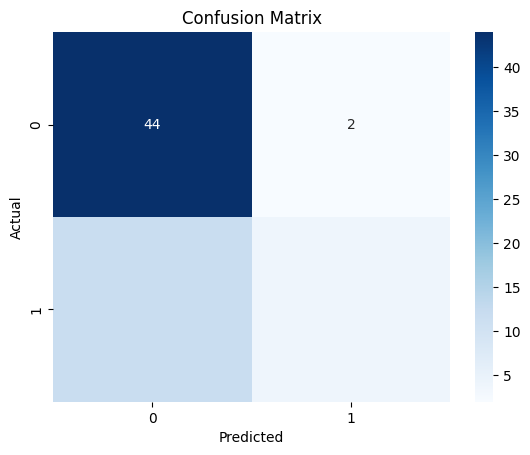

In [220]:
#import SVM from sklearn
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test are your train-test split datasets

# Create a support vector classifier
clf = SVC()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Show the classification report
print(classification_report(y_test, y_pred))

# Get accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#### Logistic Regression

              precision    recall  f1-score   support

           0       0.79      0.98      0.87        46
           1       0.80      0.25      0.38        16

    accuracy                           0.79        62
   macro avg       0.79      0.61      0.63        62
weighted avg       0.79      0.79      0.75        62

Accuracy: 0.7903225806451613


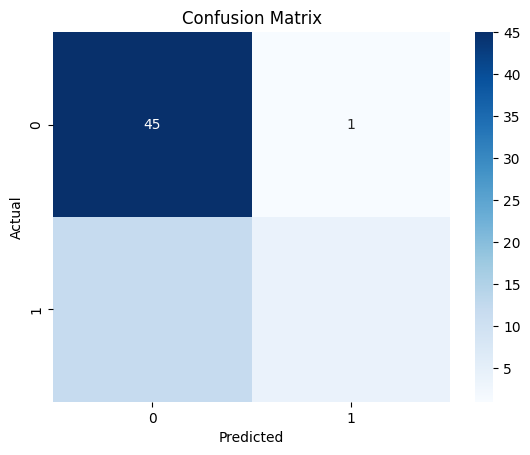

In [239]:
#import logistic regression from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test are your train-test split datasets

# Create a logistic regression classifier
clf = LogisticRegression(max_iter=10000)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Show the classification report
print(classification_report(y_test, y_pred))

# Get accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


              precision    recall  f1-score   support

           0       0.80      0.76      0.78        46
           1       0.39      0.44      0.41        16

    accuracy                           0.68        62
   macro avg       0.59      0.60      0.59        62
weighted avg       0.69      0.68      0.68        62

0.6774193548387096


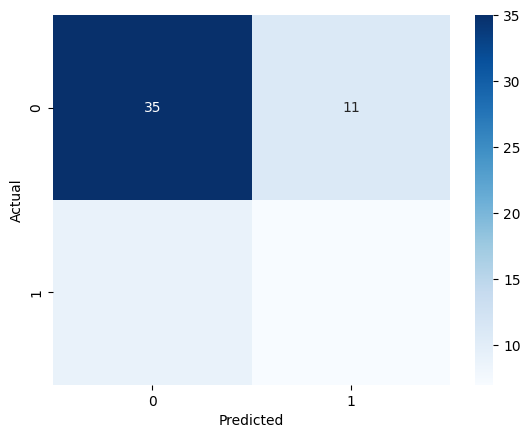

In [226]:
#import knn from sklearn
from sklearn.tree import DecisionTreeClassifier

# Crea un clasificador KNN
clf = DecisionTreeClassifier()
# Entrena el clasificador
clf.fit(X_train, y_train)

# Haz predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Muestra el reporte de clasificación
print(classification_report(y_test, y_pred))

#get accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

#create confusion matrix
from sklearn.metrics import confusion_matrix

#plot confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Finalmente predecimos las features de test y las guardamos en un archivo csv.

In [234]:
X_test = pd.read_csv('features_test.csv')
X_test = X_test.fillna(0)

# X_test = pca.transform(X_test)

# Haz predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)


#save y_pred in a file.csv with id and result. id starts from 1
df_y_pred = pd.DataFrame(y_pred, columns=['result'])
df_y_pred.index += 1
df_y_pred.index.name = 'ID'
df_y_pred.to_csv("y_pred.csv")

/Users/edgarchambilla/Desktop/UTEC_CODE/ML/venvML/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [264]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess the test set
X_test = pd.read_csv('features_test.csv')
X_test = X_test.fillna(0)  # Fill missing values with 0


# Convert the test set to a NumPy array (to match the format of the training data)
X_test_array = X_test.to_numpy()

# Assuming you have a trained logistic regression model (clf)
# and the target variable for the test set (y_test) is already defined

# Make predictions on the test set
y_pred = clf.predict(X_test_array)

# Save the predictions to a CSV file
df_y_pred = pd.DataFrame(y_pred, columns=['Target'])
df_y_pred.index += 1
df_y_pred.index.name = 'Id'
df_y_pred.to_csv('y_pred.csv')

